#### Utils

In [17]:
seeds = [418, 627, 960, 426, 16, 523, 708, 541, 747, 897, 714, 127, 657, 662, 284, 595, 852, 734, 136, 394,
             321, 200, 502, 786, 817, 264, 929, 407, 515, 411]

In [18]:
import pandas as pd
from sklearn.metrics import roc_curve, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np
from typing import Dict
from statistics import mean, stdev

def get_df(path: str, seed) -> pd.DataFrame:
    df = pd.read_csv(path, header=None)
    df = df.rename(columns={0: "inference", 1: "ground_truth"})
    df["seed"] = seed
    df["ground_truth"] = df["ground_truth"].astype(float)
    return df

def get_best_treshold(ground_truths: np.ndarray, inferences: np.ndarray):
    fpr, tpr, tresholds = roc_curve(ground_truths, inferences)
    return tresholds[np.argmin(np.abs(tpr + fpr - 1))]

def get_predictions(inferences: np.ndarray, treshold):
    return np.where(inferences >= treshold, 1, 0)

def get_scores(results: Dict):
    datasets = ["deepmirtar", "miraw", "mirtarraw"]
    metrics = {"balanced_acc": balanced_accuracy_score, "f1": f1_score, "precision": precision_score, "recall": recall_score, "auc": roc_auc_score}
    for dataset in datasets:
        metric_scores = {key:[] for key in metrics.keys()}
        for seed in seeds:
            df = results[dataset]
            df = df[df["seed"]==seed]
            ground_truths = df["ground_truth"].to_numpy()
            inferences = df["inference"].to_numpy()
            prediction_treshold = get_best_treshold(ground_truths, inferences)
            predictions = get_predictions(inferences, prediction_treshold)
            for key, metric in metrics.items():
                score = metric(ground_truths, predictions)
                metric_scores[key].append(score)
        print_metric_scores(metric_scores, dataset)

def print_metric_scores(metric_scores, dataset, graph_layer=None):
    print("##########################")
    if graph_layer:
        print("Dataset: {}, Graph layer: {}".format(dataset, graph_layer))
    else:
        print("Dataset: {}".format(dataset))
    for key, scores in metric_scores.items():
        print("Metric: {}, mean: {}, min: {}, max: {}, std: {}".format(key, mean(scores), min(scores), max(scores), stdev(scores)))
        
def get_graph_scores(results: Dict):
    datasets = ["deepmirtar", "miraw", "mirtarraw"]
    metrics = {"balanced_acc": balanced_accuracy_score, "f1": f1_score, "precision": precision_score, "recall": recall_score, "auc": roc_auc_score}
    gnn_layer_type = ["GCN", "GAT", "GRAPHSAGE"]
    for dataset in datasets:
        for gnn_layer in gnn_layer_type:
            metric_scores = {key:[] for key in metrics.keys()}
            for seed in seeds:
                df = results[dataset][gnn_layer]
                df = df[df["seed"]==seed]
                ground_truths = df["ground_truth"].to_numpy()
                inferences = df["inference"].to_numpy()
                prediction_treshold = get_best_treshold(ground_truths, inferences)
                predictions = get_predictions(inferences, prediction_treshold)
                for key, metric in metrics.items():
                    score = metric(ground_truths, predictions)
                    metric_scores[key].append(score)
            print_metric_scores(metric_scores, dataset, gnn_layer)
            
from statistics import NormalDist

def confidence_interval(data, confidence=0.95):
    dist = NormalDist.from_samples(data)
    z = NormalDist().inv_cdf((1 + confidence) / 2.)
    h = dist.stdev * z / ((len(data) - 1) ** .5)
    return dist.mean - h, dist.mean + h

### Compared methods

In [19]:
configs = [
        ("miraw", "miraw_ann", "miRAW", 128, "deepmirtar", 0.001),
        ("miraw", "miraw_ann", "miRAW", 64, "miraw", 0.001),
        ("miraw", "miraw_ann", "miRAW", 128, "mirtarraw", 0.001),
        ("deepmirtar", "deepmirtar_ann", "DeepMirTar", 512, "deepmirtar", 0.001),
        ("deepmirtar", "deepmirtar_ann", "DeepMirTar", 512, "miraw", 0.001),
        ("deepmirtar", "deepmirtar_ann", "DeepMirTar", 256, "mirtarraw", 0.001),
        ("mitar", "mitar_net", "miTAR", 16, "deepmirtar", 0.001),
        ("mitar", "mitar_net", "miTAR", 64, "miraw", 0.001),
        ("mitar", "mitar_net", "miTAR", 64, "mirtarraw", 0.001),
    ]

In [20]:
rows = []
for config in configs:
    df_list = []
    model_dir, config_prefix, method, batch_size, dataset, lr = config
    for seed in seeds:
        filename = "../../experiments/{}/results/{}_{}_config_{}_{}_{}.csv".format(model_dir, config_prefix, dataset, batch_size, seed, lr)
        df = get_df(filename, seed)
        best_treshold = get_best_treshold(df['ground_truth'], df['inference'])
        df['prediction'] = get_predictions(df['inference'], best_treshold)
        rows.append({"dataset_type": dataset,
               "batch_size": batch_size,
               "lr": lr,
               "seed": seed,
               "method": method,
               "balanced_acc": balanced_accuracy_score(df['ground_truth'], df['prediction']),
               "f1": f1_score(df['ground_truth'], df['prediction']),
               "precision": precision_score(df['ground_truth'], df['prediction']),
               "recall": recall_score(df['ground_truth'], df['prediction']),
               "auc": roc_auc_score(df['ground_truth'], df['prediction'])
              })

In [21]:
rows_df = pd.DataFrame(rows)

### graphtar

In [22]:
configs = [
        ("GCN", 128, "deepmirtar", 128, 3, "MAX", 512, 2, 0.4, 0.001),
        ("GCN", 64, "miraw", 128, 3, "MAX", 512, 2, 0.4, 0.001),
        ("GCN", 64, "mirtarraw", 128, 3, "MAX", 512, 2, 0.4, 0.001),
        ("GAT",128, "deepmirtar", 256, 5, "ADD", 128, 2, 0.4, 0.001),
        ("GAT", 512, "miraw", 256, 5, "ADD", 128, 2, 0.4, 0.001),
        ("GAT", 512, "mirtarraw", 256, 5, "ADD", 128, 2, 0.4, 0.001),
        ("GRAPHSAGE", 128, "deepmirtar", 256, 5, "ADD", 256, 3, 0.4, 0.001),
        ("GRAPHSAGE", 32, "miraw", 256, 5, "ADD", 256, 3, 0.4, 0.001),
        ("GRAPHSAGE", 256, "mirtarraw", 256, 5, "ADD", 256, 3, 0.4, 0.001),
    ]

In [23]:
rows_gnn = []
for config in configs:
    df_list = []
    gnn_layer_type, batch_size, dataset_type, graph_layer_size, n_gnn_layers, global_pooling, fc_layer_size, n_fc_layers, dropout_rate, lr = config
    for seed in seeds:
        filename = "../../experiments/graphtar/results/{}_{}_{}.csv".format(gnn_layer_type, dataset_type, seed)
        df = get_df(filename, seed)
        best_treshold = get_best_treshold(df['ground_truth'], df['inference'])
        df['prediction'] = get_predictions(df['inference'], best_treshold)
        rows_gnn.append({"dataset_type": dataset_type,
               "batch_size": batch_size,
               "lr": lr,
               "seed": seed,
               "method": gnn_layer_type,
               "balanced_acc": balanced_accuracy_score(df['ground_truth'], df['prediction']),
               "f1": f1_score(df['ground_truth'], df['prediction']),
               "precision": precision_score(df['ground_truth'], df['prediction']),
               "recall": recall_score(df['ground_truth'], df['prediction']),
               "auc": roc_auc_score(df['ground_truth'], df['prediction'])
              })

In [24]:
rows_gnn_df = pd.DataFrame(rows_gnn)
rows_gnn_df.describe()

,batch_size,lr,seed,balanced_acc,f1,precision,recall,auc
count,270.000000,2.700000e+02,270.00000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,202.666667,1.000000e-03,539.00000,0.923902,0.924086,0.924247,0.923931,0.923902
std,176.245857,6.517293e-19,249.95613,0.016513,0.016745,0.017127,0.016491,0.016513
min,32.000000,1.000000e-03,16.00000,0.867814,0.869048,0.868056,0.867572,0.867814
25%,64.000000,1.000000e-03,394.00000,0.913899,0.913376,0.913293,0.913787,0.913899
50%,128.000000,1.000000e-03,532.00000,0.922194,0.921631,0.922560,0.922251,0.922194
75%,256.000000,1.000000e-03,734.00000,0.938105,0.938045,0.938467,0.938005,0.938105
max,512.000000,1.000000e-03,960.00000,0.954891,0.955312,0.955916,0.954708,0.954891


In [25]:
common_df = pd.concat([rows_df, rows_gnn_df], axis=0)

In [26]:
common_df.groupby(["dataset_type", "method"])[["balanced_acc", "f1", "precision", "recall"]].agg(["mean", "count", "std"])

balanced_acc                        f1        \
                                mean count       std      mean count   
dataset_type method                                                    
deepmirtar   DeepMirTar     0.815364    30  0.011130  0.815908    30   
             GAT            0.922178    30  0.014595  0.922333    30   
             GCN            0.904286    30  0.013824  0.904614    30   
             GRAPHSAGE      0.915418    30  0.017762  0.915615    30   
             miRAW          0.902238    30  0.012371  0.902476    30   
             miTAR          0.927443    30  0.011969  0.927709    30   
miraw        DeepMirTar     0.875011    30  0.003707  0.875867    30   
             GAT            0.947956    30  0.003744  0.948331    30   
             GCN            0.935578    30  0.004066  0.936037    30   
             GRAPHSAGE      0.939820    30  0.003521  0.940263    30   
             miRAW          0.937830    30  0.003146  0.938281    30   
             miTAR          0.939384    30  0.003568  0.939816    30   
mirtarraw    DeepMirTar     0.826832    30  0.004147  0.826649    30   
             GAT            0.920474    30  0.005453  0.920377    30   
             GCN            0.915336    30  0.006680  0.915238    30   
             GRAPHSAGE      0.914069    30  0.005211  0.913969    30   
             miRAW          0.928059    30  0.003917  0.927995    30   
             miTAR          0.910382    30  0.008317  0.910238    30   

                                  precision                    recall        \
                              std      mean count       std      mean count   
dataset_type method                                                           
deepmirtar   DeepMirTar  0.011331  0.816572    30  0.013031  0.815290    30   
             GAT         0.015047  0.922611    30  0.015646  0.922064    30   
             GCN         0.014031  0.904645    30  0.014384  0.904596    30   
             GRAPHSAGE   0.018251  0.915746    30  0.019158  0.915495    30   
             miRAW       0.013427  0.902476    30  0.015529  0.902498    30   
             miTAR       0.011730  0.927981    30  0.011950  0.927448    30   
miraw        DeepMirTar  0.003644  0.876701    30  0.003944  0.875038    30   
             GAT         0.003848  0.948710    30  0.004033  0.947952    30   
             GCN         0.004184  0.936503    30  0.004381  0.935573    30   
             GRAPHSAGE   0.003437  0.940711    30  0.003498  0.939816    30   
             miRAW       0.003179  0.938738    30  0.003324  0.937825    30   
             miTAR       0.003715  0.940268    30  0.003971  0.939365    30   
mirtarraw    DeepMirTar  0.004372  0.826480    30  0.005526  0.826829    30   
             GAT         0.005548  0.920277    30  0.005781  0.920480    30   
             GCN         0.006695  0.915129    30  0.006859  0.915351    30   
             GRAPHSAGE   0.005247  0.913890    30  0.005547  0.914051    30   
             miRAW       0.003586  0.927892    30  0.003469  0.928099    30   
             miTAR       0.008850  0.910149    30  0.009559  0.910331    30   

                                   
                              std  
dataset_type method                
deepmirtar   DeepMirTar  0.011137  
             GAT         0.014756  
             GCN         0.014081  
             GRAPHSAGE   0.017587  
             miRAW       0.011788  
             miTAR       0.011909  
miraw        DeepMirTar  0.003726  
             GAT         0.003734  
             GCN         0.004088  
             GRAPHSAGE   0.003484  
             miRAW       0.003157  
             miTAR       0.003551  
mirtarraw    DeepMirTar  0.004131  
             GAT         0.005514  
             GCN         0.006745  
             GRAPHSAGE   0.005205  
             miRAW       0.003963  
             miTAR       0.008290

[Text(0.5, 0, 'Method'),
 Text(0, 0.5, 'F1 score'),
 Text(0.5, 1.0, 'F1 score vs target prediction method')]

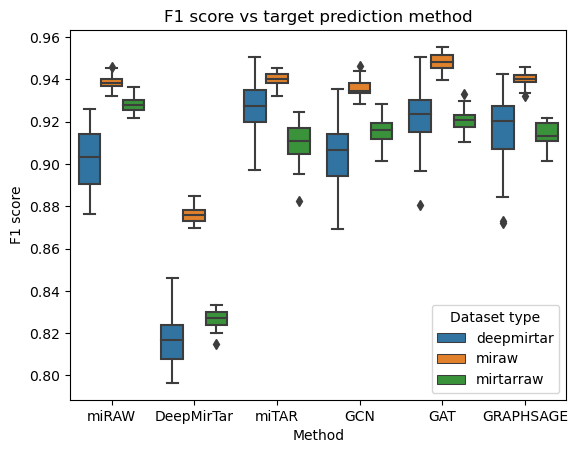

In [27]:
import seaborn as sns

df = common_df
plt = sns.boxplot(data=df, x="method", y="f1", hue="dataset_type")
plt.legend_.set_title("Dataset type")
plt.set(xlabel ="Method", ylabel = "F1 score", title ='F1 score vs target prediction method')

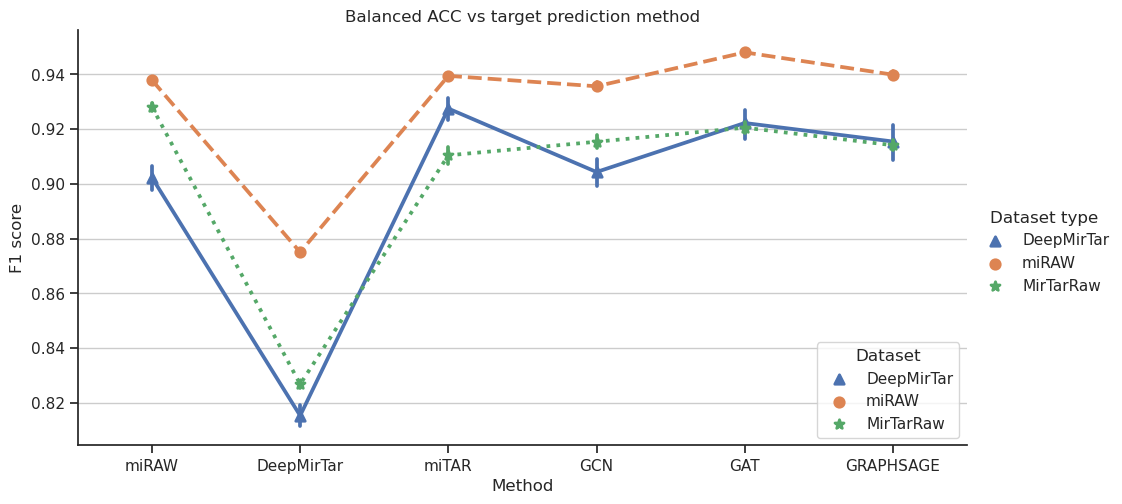

In [82]:
import seaborn as sns
import matplotlib.pyplot as pl
sns.set_theme(style='white')
sns.set_style("ticks",{'axes.grid' : True})
df = common_df
df.loc[df["dataset_type"]=="miraw","dataset_type"]= "miRAW"
df.loc[df["dataset_type"]=="mirtarraw","dataset_type"]= "MirTarRaw"
df.loc[df["dataset_type"]=="deepmirtar","dataset_type"]= "DeepMirTar"
plt = sns.catplot(
    data=df, x="method", y="balanced_acc", hue="dataset_type",
    # palette={"male": "g", "female": "m"},
    markers=["^", "o", "*"], linestyles=["-", "--", ":"],
    kind="point",
    errorbar=("ci", 95),
    aspect=8/4
)

plt._legend.set_title("Dataset type") 
pl.legend(loc="lower right", title="Dataset")
plt.set(xlabel ="Method", ylabel = "F1 score", title ='Balanced ACC vs target prediction method')

### Confidence intervals

In [62]:
confidence_intervals_rows = []
for dataset_type in common_df['dataset_type'].unique():
    for method in common_df['method'].unique():
        for metric in ["balanced_acc", "f1", "precision", "recall", "auc"]:
            low, high = confidence_interval(common_df[(common_df["method"] == method) & (common_df["dataset_type"] == dataset_type)][metric])
            confidence_intervals_rows.append(
                {
                    "dataset_type": dataset_type,
                    "method": method,
                    "metric": metric,
                    "ci": f"{round(low,3)}-{round(high, 3)}",
                }
            )
ci_df = pd.DataFrame(confidence_intervals_rows)

In [65]:
ci_df[(ci_df['dataset_type']=="mirtarraw")]

,dataset_type,method,metric,ci
60,mirtarraw,miRAW,balanced_acc,0.927-0.929
61,mirtarraw,miRAW,f1,0.927-0.929
62,mirtarraw,miRAW,precision,0.927-0.929
63,mirtarraw,miRAW,recall,0.927-0.93
64,mirtarraw,miRAW,auc,0.927-0.929
65,mirtarraw,DeepMirTar,balanced_acc,0.825-0.828
66,mirtarraw,DeepMirTar,f1,0.825-0.828
67,mirtarraw,DeepMirTar,precision,0.824-0.828
68,mirtarraw,DeepMirTar,recall,0.825-0.828
69,mirtarraw,DeepMirTar,auc,0.825-0.828
